## **0.Dataset**

In [1]:
!gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191
From (redirected): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191&confirm=t&uuid=aafdb173-ef80-45f0-b67a-9b129a4a1427
To: /content/vqa_coco_dataset.zip
100% 196M/196M [00:08<00:00, 23.6MB/s]


In [2]:
!unzip -q vqa_coco_dataset.zip

## **1. Import libraries and set random seed**

In [3]:
!pip install timm==0.8.17.dev0
!pip install torchtext==0.15.1
!pip install torchvision==0.16.0
!pip install torchaudio==2.1.0
!pip install torch==2.1.0
!pip install transformers==4.27.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 827.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [4]:
import torch
import torch.nn as nn
import torchtext
import os
import random
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt
import time

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

### **2. Process Dataset**

In [6]:
def making_dataset(dataset_path, data):
  with open(dataset_path, 'r') as f:
    lines = f.readlines()
    for line in lines:

      temp = line.split('\t')
      qa = temp[1].split('?')

      if len(qa) == 3:
        answer = qa[2].strip()
      elif len(qa) == 2:
        answer = qa[1].strip()

      data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }

      data.append(data_sample)

  return data

In [7]:
train_data = []
val_data = []
test_data = []

train_set_path = "/content/vaq2.0.TrainImages.txt"
val_set_path = "/content/vaq2.0.DevImages.txt"
test_set_path = "/content/vaq2.0.TestImages.txt"


train_data = making_dataset(train_set_path, train_data)
val_data = making_dataset(val_set_path, val_data)
test_data = making_dataset(test_set_path, test_data)



**Example**

In [8]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

print(train_data[0])

7846
1952
2022
{'image_path': 'COCO_val2014_000000393225.jpg', 'question': 'Is this a creamy soup ?', 'answer': 'no'}


### **3. Data Preprocessing**

In [9]:
eng = spacy.load("en_core_web_sm")
"""
Use spacy to load "small english model"
Already trained for tokenization, POS tagging, dependency parsing,
NER (Named Entity Recognition)
"""

def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']

        yield [token.text for token in eng.tokenizer(question)]
        # Use yield for this task is better than return


vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])


In [10]:
len(vocab)

1678

In [11]:
def tokenize(question, max_seq_len):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

In [12]:
question = "Is this a toy ?"
max_seq_len = 15

print(tokenize(question, max_seq_len))

[6, 5, 7, 168, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
def detokenize(sequence):
    idx_to_token = vocab.get_itos()

    tokens = [idx_to_token[idx] for idx in sequence if idx_to_token[idx] not in ['<pad>', '<sos>', '<eos>', '<unk>']]

    return " ".join(tokens)

In [14]:
res = detokenize(tokenize(question, max_seq_len))
print(res)

Is this a toy ?


In [15]:
classes = set([sample['answer'] for sample in train_data])
label2idx = {
    cls_name : idx for idx, cls_name in enumerate(classes)
}
idx2label = {
    idx : cls_name for idx, cls_name in enumerate(classes)
}

print(label2idx)

{'yes': 0, 'no': 1}


### **4. Create Pytorch Dataset**

In [16]:
class VQADataset(Dataset):
  def __init__(
      self,
      data,
      label2idx,
      max_seq_len=20,
      transform=None,
      img_dir='val2014-resised/'
      ):
    self.transform = transform
    self.data = data
    self.max_seq_len = max_seq_len
    self.img_dir = img_dir
    self.label2idx = label2idx

  def __len__(self):
        return len(self.data)

  def __getitem__(self, index):
    img_path = os.path.join(
        self.img_dir, self.data[index]['image_path']
    )
    img = Image.open(img_path).convert('RGB')

    if self.transform is not None:
        img = self.transform(img)

    question = self.data[index]['question']
    question = tokenize(question, self.max_seq_len)
    question = torch.tensor(question, dtype=torch.long)

    label = self.data[index]['answer']
    label = label2idx[label]
    label = torch.tensor(label, dtype=torch.long)

    return img, question, label



**Augmentation**

In [17]:
"""
Resize : resize to 224x224
CenterCrop: keep the center 180x180
ColorJitter: Randomly changing brightness, contrast, sat
RandomHorFlip : randomly flip the image
GaussianBlur : apply Gaussian blur to the image with a kernel size of 3
Normalize: using the mean and standard deviation of the ImageNet dataset
"""

data_transform = {
    'train': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.CenterCrop(size=180),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

In [18]:
train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    transform=data_transform['train']
)
val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    transform=data_transform['val']
)
test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    transform=data_transform['val']
)

In [19]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## **5.Create VQA Model**

In [20]:
class VQAModel(nn.Module):
  def __init__(
      self,
      n_classes,
      img_model_name,
      embeddding_dim,
      n_layers=2,
      hidden_size=256,
      drop_p=0.2
  ):
    super(VQAModel, self).__init__()
    self.image_encoder = timm.create_model(
        img_model_name,
        pretrained=True,
        num_classes=hidden_size
        ) # using pretrained model

    for param in self.image_encoder.parameters():
      param.requires_grad = True
      # Full finetuning (Update all the param from the model)

    self.embedding = nn.Embedding(len(vocab), embeddding_dim)

    self.lstm1 = nn.LSTM(
        input_size=embeddding_dim,
        hidden_size=hidden_size,
        num_layers=n_layers,
        batch_first=True,
        bidirectional=True,
        dropout=drop_p
    )
    self.fc1 = nn.Linear(hidden_size * 3, hidden_size)
    self.dropout = nn.Dropout(drop_p)
    self.gelu = nn.GELU()
    self.fc2 = nn.Linear(hidden_size, n_classes)


  def forward(self, img, text):
    img_features = self.image_encoder(img)

    text_emb = self.embedding(text)
    lstm_out, _ = self.lstm1(text_emb)

    lstm_out = lstm_out[:, -1, :]

    combined = torch.cat((img_features, lstm_out), dim=1)
    x = self.fc1(combined)
    x = self.gelu(x)
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [21]:
n_classes = len(classes)
img_model_name = 'resnet18'
hidden_size = 256
n_layers = 2
embeddding_dim = 128
drop_p = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embeddding_dim=embeddding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_p=drop_p
).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [22]:
images, questions, labels = next(iter(train_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = model(images, questions)
    print(output.shape)

torch.Size([256, 2])


### **6. Training**

In [23]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)
            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [24]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        start = time.time()
        batch_train_losses = []

        model.train()
        for idx, (images, questions, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc} \t Time: {time.time() - start:.2f} seconds')

        scheduler.step()

    return train_losses, val_losses

In [25]:
lr = 1e-3
epochs = 50

scheduler_step_size = epochs * 0.8
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [26]:
train_losses, val_losses = fit(
      model,
          train_loader,
              val_loader,
                  criterion,
                      optimizer,
                          scheduler,
                              device,
                                  epochs
                                  )


EPOCH 1:	Train loss: 0.6976	Val loss: 0.7788	Val Acc: 0.5317622950819673 	 Time: 67.56 seconds
EPOCH 2:	Train loss: 0.6966	Val loss: 0.6902	Val Acc: 0.5358606557377049 	 Time: 62.61 seconds
EPOCH 3:	Train loss: 0.6943	Val loss: 0.6913	Val Acc: 0.5322745901639344 	 Time: 62.78 seconds
EPOCH 4:	Train loss: 0.6926	Val loss: 0.6913	Val Acc: 0.5194672131147541 	 Time: 62.84 seconds
EPOCH 5:	Train loss: 0.6928	Val loss: 0.6905	Val Acc: 0.5445696721311475 	 Time: 62.96 seconds
EPOCH 6:	Train loss: 0.6907	Val loss: 0.7103	Val Acc: 0.5271516393442623 	 Time: 62.70 seconds
EPOCH 7:	Train loss: 0.6908	Val loss: 0.6935	Val Acc: 0.5353483606557377 	 Time: 62.95 seconds
EPOCH 8:	Train loss: 0.6902	Val loss: 0.6885	Val Acc: 0.5343237704918032 	 Time: 63.06 seconds
EPOCH 9:	Train loss: 0.6893	Val loss: 0.6920	Val Acc: 0.5256147540983607 	 Time: 62.52 seconds
EPOCH 10:	Train loss: 0.6896	Val loss: 0.6925	Val Acc: 0.5281762295081968 	 Time: 62.60 seconds
EPOCH 11:	Train loss: 0.6874	Val loss: 0.6873	Val

KeyboardInterrupt: 

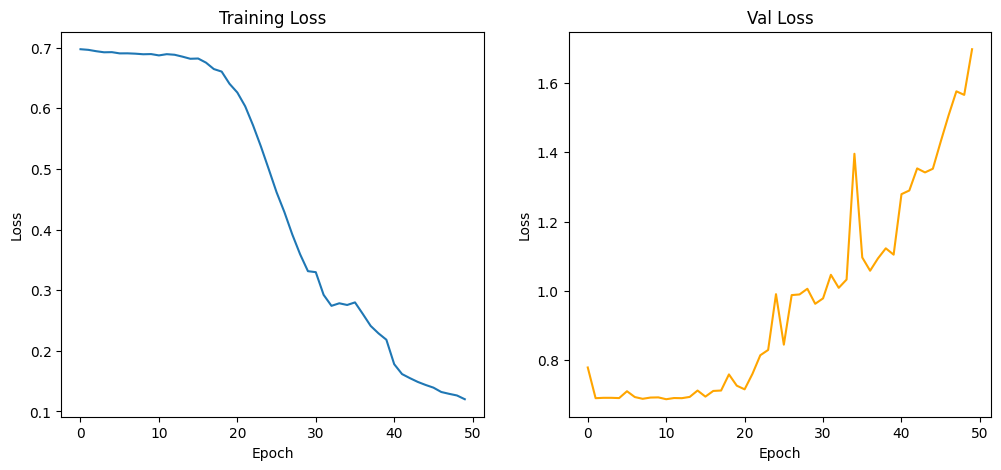

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [28]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.5102459016393442
Test accuracy:  0.509891196834817


## 8. Inference

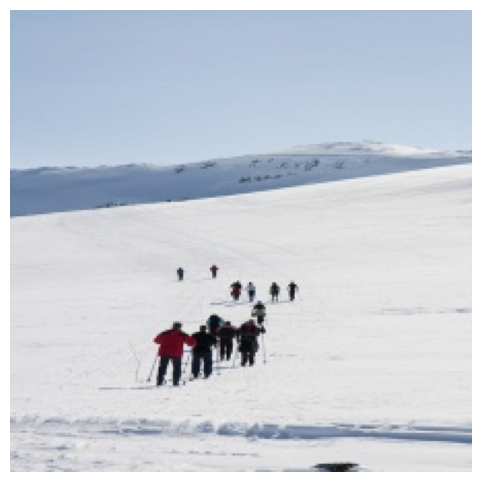

Question: Are there any trees visible ?
Groundtruth: no
Predicted: no


In [31]:
idx = 10
img_name = test_data[idx]['image_path']
img_path = os.path.join('val2014-resised', img_name)
question = test_data[idx]['question']
label = test_data[idx]['answer']

max_seq_len = 15
question_processed = torch.tensor(tokenize(question, max_seq_len)).unsqueeze(0).to(device)

img = Image.open(img_path).convert("RGB")
img_processed = data_transform['val'](img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img_processed, question_processed)
    pred = torch.argmax(output, dim=1).item()

reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    transforms.ToPILImage()
])
image_vis = reverse_transform(img_processed.squeeze(0).cpu())

origin_quest = detokenize(question_processed.squeeze(0).cpu().tolist())

plt.figure(figsize=(6, 6))
plt.imshow(image_vis)
plt.axis('off')
plt.show()

print(f'Question: {origin_quest}')
print(f'Groundtruth: {label}')
print(f'Predicted: {idx2label[pred]}')